# 02 · Fine-tune DistilBERT on OpenStack Logs

A compact notebook that loads the pre-trained HDFS checkpoint, fine-tunes it on OpenStack logs with optional replay samples, and evaluates the resulting anomaly detector.

## Pipeline Overview

1. Load configuration plus OpenStack train/validation/test splits (with optional HDFS replay).
2. Instantiate tokenizer, recover the latest HDFS checkpoint, and resize embeddings.
3. Build DataLoaders with an MLM collator that masks tokens consistently.
4. Train with `accelerate`, cosine schedule, and early stopping on validation loss.
5. Calibrate a loss-based anomaly threshold on the validation set and score the test set.
6. Persist checkpoints, metrics, and visual diagnostics under `artifacts/`.

In [9]:
import gc
import json
import math
from dataclasses import dataclass
from pathlib import Path
from typing import Dict, List, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import yaml
from accelerate import Accelerator
from datasets import Dataset, load_from_disk
from sklearn.metrics import (
    accuracy_score,
    average_precision_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_recall_curve,
    precision_score,
    recall_score,
    roc_auc_score,
)
from torch.utils.data import DataLoader
from transformers import (
    AutoConfig,
    AutoModelForMaskedLM,
    AutoTokenizer,
    DataCollatorForLanguageModeling,
    get_scheduler,
)
from tqdm.auto import tqdm

plt.style.use('seaborn-v0_8')
plt.rcParams['figure.dpi'] = 120

def set_seed(value: int) -> None:
    torch.manual_seed(value)
    np.random.seed(value)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(value)

set_seed(1337)
print(f"✅ Environment detected: {'CUDA' if torch.cuda.is_available() else 'CPU'} available")

✅ Environment detected: CUDA available


In [10]:
def load_yaml(path: Path) -> Dict:
    with path.open('r') as fh:
        return yaml.safe_load(fh)

DATA_CFG = load_yaml(Path('../configs/data.yaml'))
TRAIN_CFG = load_yaml(Path('../configs/train_openstack.yaml'))

print('Configurations loaded:')
print(f"  • Data config : {DATA_CFG['preprocessing']['parquet_dir']}")
print(f"  • Train config: {TRAIN_CFG['checkpointing']['output_dir']}")

Configurations loaded:
  • Data config : artifacts/datasets
  • Train config: artifacts/logbert-mlm-os


In [11]:
parquet_dir = Path(DATA_CFG['preprocessing']['parquet_dir'])
seed = TRAIN_CFG['seed']
set_seed(seed)

train_ds = load_from_disk(str(parquet_dir / 'openstack_train_hf'))
val_ds = load_from_disk(str(parquet_dir / 'openstack_val_hf'))
test_ds = load_from_disk(str(parquet_dir / 'openstack_test_hf'))

print(f"Loaded OpenStack splits → train={len(train_ds):,}, val={len(val_ds):,}, test={len(test_ds):,}")

replay_cfg = TRAIN_CFG['replay']
if replay_cfg['enabled']:
    print('Replay sampling enabled; mixing HDFS data...')
    hdfs_ds = load_from_disk(str(parquet_dir / 'hdfs_train_hf'))
    replay_count = max(1, int(len(train_ds) * replay_cfg['ratio']))
    replay_subset = hdfs_ds.shuffle(seed=seed).select(range(replay_count))

    base_df = train_ds.to_pandas()
    replay_df = replay_subset.to_pandas()

    for col in base_df.columns:
        if col not in replay_df.columns:
            if col == 'anomaly_label':
                replay_df[col] = 0
            elif 'template_id' in col:
                replay_df[col] = -1
            else:
                replay_df[col] = None

    for col in replay_df.columns:
        if col not in base_df.columns:
            if col == 'anomaly_label':
                base_df[col] = 0
            elif 'template_id' in col:
                base_df[col] = -1
            else:
                base_df[col] = None

    template_cols = [c for c in base_df.columns if 'template_id' in c]
    for col in template_cols:
        base_df[col] = pd.to_numeric(base_df[col], errors='coerce').fillna(-1).astype('int64')
        replay_df[col] = pd.to_numeric(replay_df[col], errors='coerce').fillna(-1).astype('int64')

    replay_df = replay_df[base_df.columns]
    mixed_df = pd.concat([base_df, replay_df], ignore_index=True)
    mixed_df = mixed_df.sample(frac=1.0, random_state=seed).reset_index(drop=True)
    train_ds = Dataset.from_pandas(mixed_df, preserve_index=False)
    print(f"Mixed {replay_count:,} replay rows; new train size: {len(train_ds):,}")
else:
    print('Replay disabled; using OpenStack train split only.')

Loaded OpenStack splits → train=166,256, val=20,782, test=20,782
Replay sampling enabled; mixing HDFS data...
Mixed 16,625 replay rows; new train size: 182,881
Mixed 16,625 replay rows; new train size: 182,881


In [12]:
tokenizer_dir = Path(TRAIN_CFG['artifacts']['tokenizer_dir'])
if not tokenizer_dir.exists():
    raise FileNotFoundError(f'Tokenizer directory not found: {tokenizer_dir}')

tokenizer = AutoTokenizer.from_pretrained(tokenizer_dir, use_fast=True)
print(f"Tokenizer loaded from {tokenizer_dir} (vocab size={len(tokenizer)})")

base_dir = Path(TRAIN_CFG['base_checkpoint_dir'])
if not base_dir.exists():
    raise FileNotFoundError(f'Base checkpoint directory missing: {base_dir}')

candidates: List[Path] = []
candidates.extend(sorted(base_dir.glob('epoch*/config.json')))
candidates.extend(sorted(base_dir.glob('step*/config.json')))
if not candidates:
    raise FileNotFoundError(f'No checkpoint files discovered under {base_dir}')

checkpoint_path = candidates[-1].parent
print(f"Loading pretrained DistilBERT checkpoint from {checkpoint_path}")

config = AutoConfig.from_pretrained(checkpoint_path)
model = AutoModelForMaskedLM.from_pretrained(checkpoint_path, config=config)
model.resize_token_embeddings(len(tokenizer))
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Tokenizer loaded from artifacts/tokenizer (vocab size=30531)
Loading pretrained DistilBERT checkpoint from artifacts/logbert-mlm-hdfs/step_epoch3_step800000
Model parameters: 66,992,451


In [13]:
MAX_LENGTH = int(TRAIN_CFG['sequence']['max_length'])
MLM_PROB = float(TRAIN_CFG['sequence']['mlm_probability'])
PAD_TO = int(TRAIN_CFG['sequence'].get('pad_to_multiple_of', 8))

mlm_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=True,
    mlm_probability=MLM_PROB,
    pad_to_multiple_of=PAD_TO,
    return_tensors='pt',
)


def _prepare_features(examples: List[Dict]) -> List[Dict]:
    features: List[Dict] = []
    for example in examples:
        input_ids = example['input_ids'][:MAX_LENGTH]
        attention_mask = example.get('attention_mask', [1] * len(input_ids))[:MAX_LENGTH]
        features.append({'input_ids': input_ids, 'attention_mask': attention_mask})
    return features


def collate_train(examples: List[Dict]) -> Dict[str, torch.Tensor]:
    features = _prepare_features(examples)
    return mlm_collator(features)


def collate_eval(examples: List[Dict]) -> Dict[str, torch.Tensor]:
    labels = torch.tensor([e.get('anomaly_label', 0) for e in examples], dtype=torch.long)
    features = _prepare_features(examples)
    batch = mlm_collator(features)
    batch['anomaly_label'] = labels
    return batch

train_loader = DataLoader(
    train_ds,
    batch_size=TRAIN_CFG['training']['train_batch_size_per_device'],
    shuffle=True,
    collate_fn=collate_train,
)
val_loader = DataLoader(
    val_ds,
    batch_size=TRAIN_CFG['training']['eval_batch_size_per_device'],
    shuffle=False,
    collate_fn=collate_eval,
)
test_loader = DataLoader(
    test_ds,
    batch_size=TRAIN_CFG['training']['eval_batch_size_per_device'],
    shuffle=False,
    collate_fn=collate_eval,
)

print('DataLoaders ready:')
print(f"  • train batches: {len(train_loader):,}")
print(f"  • val batches  : {len(val_loader):,}")
print(f"  • test batches : {len(test_loader):,}")

DataLoaders ready:
  • train batches: 11,431
  • val batches  : 650
  • test batches : 650


In [14]:
training_cfg = TRAIN_CFG['training']
optimizer_cfg = TRAIN_CFG['optimizer']
checkpoint_dir = Path(TRAIN_CFG['checkpointing']['output_dir'])
checkpoint_dir.mkdir(parents=True, exist_ok=True)

max_grad_norm = float(training_cfg['max_grad_norm'])
epochs = int(training_cfg['epochs'])
patience = int(training_cfg['patience'])
min_delta = float(training_cfg['min_delta'])
log_every = int(training_cfg['log_every'])
checkpoint_fraction = float(training_cfg['checkpoint_fraction'])

num_update_steps_per_epoch = math.ceil(len(train_loader) / training_cfg['grad_accumulation_steps'])
total_training_steps = num_update_steps_per_epoch * epochs

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=float(optimizer_cfg['lr']),
    betas=tuple(optimizer_cfg['betas']),
    eps=float(optimizer_cfg['eps']),
    weight_decay=float(optimizer_cfg['weight_decay']),
)

lr_scheduler = get_scheduler(
    name=optimizer_cfg['scheduler'],
    optimizer=optimizer,
    num_warmup_steps=int(optimizer_cfg['warmup_steps']),
    num_training_steps=total_training_steps,
)

accelerator = Accelerator(
    gradient_accumulation_steps=training_cfg['grad_accumulation_steps'],
    mixed_precision=TRAIN_CFG['precision']['mixed_precision'] if torch.cuda.is_available() else 'no',
)
model, optimizer, train_loader, lr_scheduler = accelerator.prepare(
    model, optimizer, train_loader, lr_scheduler
)

def free_cuda() -> None:
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    gc.collect()

print('Accelerator configured.')

Accelerator configured.


In [15]:
def mean_mlm_loss(model: AutoModelForMaskedLM, dataloader: DataLoader) -> float:
    model.eval()
    losses: List[float] = []
    with torch.no_grad():
        for batch in dataloader:
            batch = {k: v.to(accelerator.device) if isinstance(v, torch.Tensor) else v for k, v in batch.items()}
            batch.pop('anomaly_label', None)
            loss = model(**batch).loss.detach().float()
            losses.append(loss.cpu().item())
    model.train()
    return float(np.mean(losses)) if losses else 0.0


def collect_sample_losses(model: AutoModelForMaskedLM, dataloader: DataLoader) -> Tuple[np.ndarray, np.ndarray]:
    model.eval()
    sample_losses: List[float] = []
    labels: List[int] = []
    loss_fct = torch.nn.CrossEntropyLoss(reduction='none', ignore_index=-100)

    with torch.no_grad():
        for batch in dataloader:
            labels.extend(batch['anomaly_label'].tolist())
            inputs = {k: v.to(accelerator.device) for k, v in batch.items() if k != 'anomaly_label'}
            outputs = model(**inputs)
            logits = outputs.logits
            mlm_labels = inputs['labels']

            token_loss = loss_fct(logits.view(-1, logits.size(-1)), mlm_labels.view(-1))
            token_loss = token_loss.view(logits.size(0), -1)
            mask = (mlm_labels != -100)

            for tl, m in zip(token_loss, mask):
                if m.any():
                    sample_losses.append(tl[m].mean().item())
                else:
                    sample_losses.append(0.0)
    model.train()
    return np.array(sample_losses), np.array(labels)


def sweep_threshold(losses: np.ndarray, labels: np.ndarray, metric: str = 'f1') -> Tuple[float, pd.DataFrame]:
    percentiles = np.linspace(60, 99.5, 80)
    thresholds = np.unique(np.percentile(losses, percentiles))

    records: List[Dict[str, float]] = []
    best_threshold = thresholds[0]
    best_score = -np.inf

    for threshold in thresholds:
        preds = (losses >= threshold).astype(int)
        record = {
            'threshold': float(threshold),
            'accuracy': accuracy_score(labels, preds),
            'precision': precision_score(labels, preds, zero_division=0),
            'recall': recall_score(labels, preds, zero_division=0),
            'f1': f1_score(labels, preds, zero_division=0),
        }
        records.append(record)
        if record[metric] > best_score:
            best_score = record[metric]
            best_threshold = float(threshold)

    return best_threshold, pd.DataFrame(records)


def classification_metrics(losses: np.ndarray, labels: np.ndarray, threshold: float) -> Dict[str, float]:
    preds = (losses >= threshold).astype(int)
    cm = confusion_matrix(labels, preds)
    tn, fp, fn, tp = cm.ravel()
    metrics = {
        'threshold': threshold,
        'accuracy': accuracy_score(labels, preds),
        'precision': precision_score(labels, preds, zero_division=0),
        'recall': recall_score(labels, preds, zero_division=0),
        'f1': f1_score(labels, preds, zero_division=0),
        'roc_auc': roc_auc_score(labels, losses),
        'average_precision': average_precision_score(labels, losses),
        'tn': int(tn),
        'fp': int(fp),
        'fn': int(fn),
        'tp': int(tp),
    }
    return metrics

In [16]:
history: List[Dict[str, float]] = []
best_val = float('inf')
wait = 0
best_checkpoint_path = checkpoint_dir / 'best'
checkpoint_interval = max(1, int(len(train_loader) * checkpoint_fraction))

print('🚀 Starting fine-tuning loop...')
for epoch in range(1, epochs + 1):
    model.train()
    running_losses: List[float] = []
    progress = tqdm(total=len(train_loader), desc=f'Epoch {epoch}', disable=not accelerator.is_local_main_process)

    for step, batch in enumerate(train_loader, start=1):
        with accelerator.accumulate(model):
            outputs = model(**batch)
            loss = outputs.loss
            accelerator.backward(loss)

            if accelerator.sync_gradients:
                accelerator.clip_grad_norm_(model.parameters(), max_grad_norm)

            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()

        running_losses.append(loss.detach().float().item())

        if accelerator.is_main_process and step % log_every == 0:
            progress.set_postfix(loss=np.mean(running_losses[-log_every:]), lr=lr_scheduler.get_last_lr()[0])
        progress.update(1)

        if accelerator.is_main_process and checkpoint_interval and step % checkpoint_interval == 0:
            ckpt_dir = checkpoint_dir / f'epoch{epoch}_step{step}'
            ckpt_dir.mkdir(parents=True, exist_ok=True)
            accelerator.unwrap_model(model).save_pretrained(ckpt_dir)
            tokenizer.save_pretrained(ckpt_dir / 'tokenizer')

    progress.close()
    train_loss = float(np.mean(running_losses)) if running_losses else 0.0

    val_loss = mean_mlm_loss(accelerator.unwrap_model(model), val_loader)
    history.append({'epoch': epoch, 'train_loss': train_loss, 'val_loss': val_loss})
    if accelerator.is_main_process:
        print(f"Epoch {epoch}: train_loss={train_loss:.4f}, val_loss={val_loss:.4f}")

    if val_loss + min_delta < best_val:
        wait = 0
        best_val = val_loss
        if accelerator.is_main_process:
            best_checkpoint_path.mkdir(parents=True, exist_ok=True)
            accelerator.unwrap_model(model).save_pretrained(best_checkpoint_path)
            tokenizer.save_pretrained(best_checkpoint_path / 'tokenizer')
            print('✅ Best checkpoint updated')
    else:
        wait += 1
        if accelerator.is_main_process:
            print(f'⏳ Early-stopping patience {wait}/{patience}')
        if wait >= patience:
            if accelerator.is_main_process:
                print('🛑 Early stopping triggered')
            break

accelerator.wait_for_everyone()
free_cuda()

if best_checkpoint_path.exists():
    model = AutoModelForMaskedLM.from_pretrained(best_checkpoint_path, config=config)
    model.resize_token_embeddings(len(tokenizer))
    model = model.to(accelerator.device)
    print(f"Reloaded best checkpoint from {best_checkpoint_path}")
else:
    model = accelerator.unwrap_model(model)

history_df = pd.DataFrame(history)
display(history_df)

🚀 Starting fine-tuning loop...


Epoch 1:   0%|          | 0/11431 [00:00<?, ?it/s]

[2025-09-29 21:00:58,944] [INFO] [real_accelerator.py:161:get_accelerator] Setting ds_accelerator to cuda (auto detect)
Epoch 1: train_loss=1.0058, val_loss=0.0535
✅ Best checkpoint updated


Epoch 2:   0%|          | 0/11431 [00:00<?, ?it/s]

Epoch 2: train_loss=0.0766, val_loss=0.0393
✅ Best checkpoint updated


Epoch 3:   0%|          | 0/11431 [00:00<?, ?it/s]

Epoch 3: train_loss=0.0659, val_loss=0.0344
✅ Best checkpoint updated


Epoch 4:   0%|          | 0/11431 [00:00<?, ?it/s]

Epoch 4: train_loss=0.0625, val_loss=0.0335
✅ Best checkpoint updated


Epoch 5:   0%|          | 0/11431 [00:00<?, ?it/s]

Epoch 5: train_loss=0.0614, val_loss=0.0333
⏳ Early-stopping patience 1/2
Reloaded best checkpoint from artifacts/logbert-mlm-os/best


,epoch,train_loss,val_loss
0,1,1.005753,0.053524
1,2,0.076590,0.039275
2,3,0.065869,0.034363
3,4,0.062460,0.033460
4,5,0.061406,0.033305


In [17]:
val_losses, val_labels = collect_sample_losses(model, val_loader)
threshold, sweep_df = sweep_threshold(val_losses, val_labels, metric='f1')
print(f"Validation-derived threshold: {threshold:.4f}")

trained_threshold = threshold

metrics_dir = Path(TRAIN_CFG['artifacts']['metrics_dir'])
metrics_dir.mkdir(parents=True, exist_ok=True)

sweep_path = metrics_dir / 'openstack_threshold_sweep.csv'
sweep_df.to_csv(sweep_path, index=False)
print(f"Saved threshold sweep to {sweep_path}")

val_metrics = classification_metrics(val_losses, val_labels, threshold)
print('Validation metrics:')
display(pd.DataFrame([val_metrics]).set_index('threshold'))

print('Scoring test set...')
test_losses, test_labels = collect_sample_losses(model, test_loader)
test_metrics = classification_metrics(test_losses, test_labels, threshold)
display(pd.DataFrame([test_metrics]).set_index('threshold'))

report_text = classification_report(test_labels, (test_losses >= threshold).astype(int), target_names=['Normal', 'Anomaly'], zero_division=0)
print(report_text)

metrics_payload = {
    'validation': val_metrics,
    'test': test_metrics,
    'threshold': threshold,
    'history': history,
}
metrics_path = metrics_dir / 'openstack_finetune_metrics.json'
metrics_path.write_text(json.dumps(metrics_payload, indent=2))
print(f"Metrics saved to {metrics_path}")

Validation-derived threshold: 0.0000
Saved threshold sweep to artifacts/metrics/openstack/openstack_threshold_sweep.csv
Validation metrics:


,accuracy,precision,recall,f1,roc_auc,average_precision,tn,fp,fn,tp
threshold,,,,,,,,,,
0.000027,0.600857,0.111993,0.504881,0.183322,0.595478,0.109857,11556,7382,913,931


Scoring test set...


,accuracy,precision,recall,f1,roc_auc,average_precision,tn,fp,fn,tp
threshold,,,,,,,,,,
0.000027,0.594553,0.111806,0.514379,0.183685,0.599977,0.112138,11408,7531,895,948


              precision    recall  f1-score   support

      Normal       0.93      0.60      0.73     18939
     Anomaly       0.11      0.51      0.18      1843

    accuracy                           0.59     20782
   macro avg       0.52      0.56      0.46     20782
weighted avg       0.85      0.59      0.68     20782

Metrics saved to artifacts/metrics/openstack/openstack_finetune_metrics.json


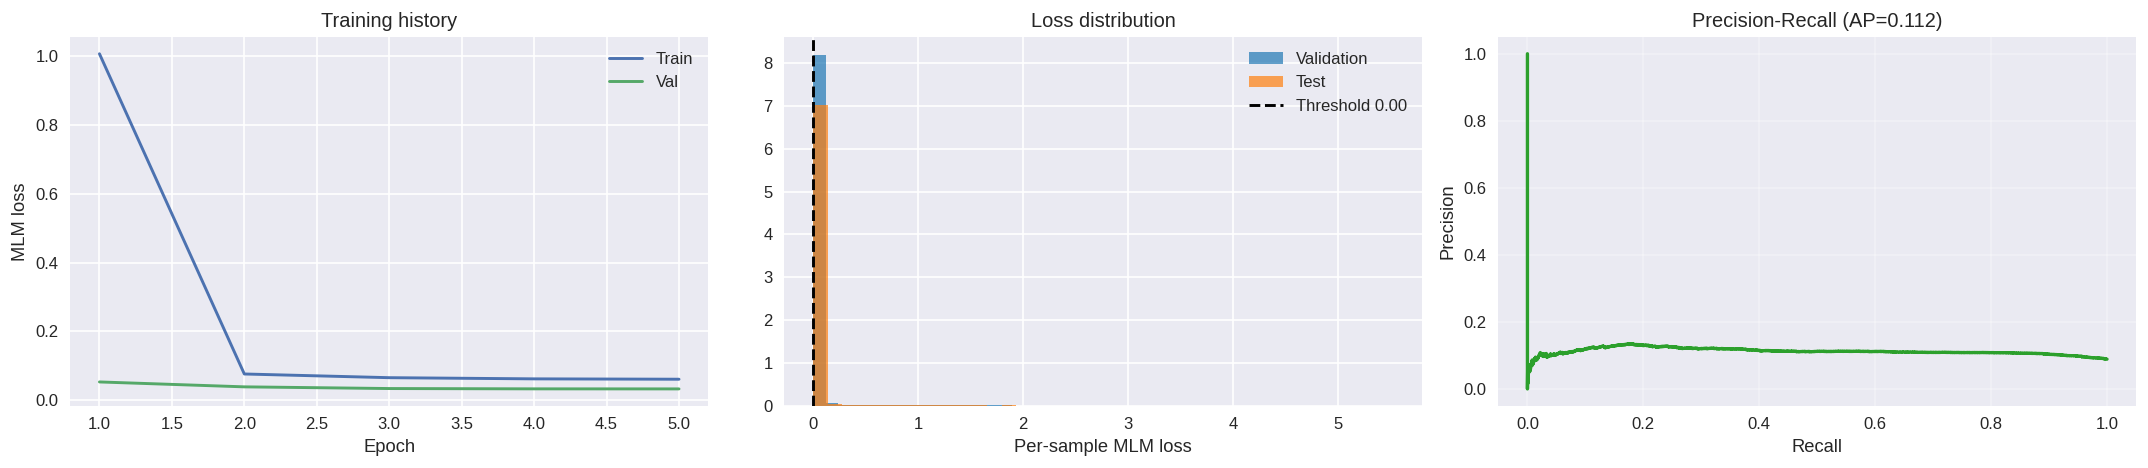

Diagnostic plot saved to artifacts/eval/openstack_finetune_diagnostics.png


In [18]:
fig, axes = plt.subplots(1, 3, figsize=(18, 4))

if not history_df.empty:
    axes[0].plot(history_df['epoch'], history_df['train_loss'], label='Train')
    axes[0].plot(history_df['epoch'], history_df['val_loss'], label='Val')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('MLM loss')
    axes[0].set_title('Training history')
    axes[0].legend()
else:
    axes[0].axis('off')

axes[1].hist(val_losses, bins=40, alpha=0.7, label='Validation', color='#1f77b4', density=True)
axes[1].hist(test_losses, bins=40, alpha=0.7, label='Test', color='#ff7f0e', density=True)
axes[1].axvline(threshold, color='black', linestyle='--', label=f'Threshold {threshold:.2f}')
axes[1].set_title('Loss distribution')
axes[1].set_xlabel('Per-sample MLM loss')
axes[1].legend()

precision_curve, recall_curve, pr_thresholds = precision_recall_curve(test_labels, test_losses)
axes[2].plot(recall_curve, precision_curve, color='#2ca02c', lw=2)
axes[2].set_title(f'Precision-Recall (AP={average_precision_score(test_labels, test_losses):.3f})')
axes[2].set_xlabel('Recall')
axes[2].set_ylabel('Precision')
axes[2].grid(True, alpha=0.3)

fig.tight_layout()
plot_path = Path(TRAIN_CFG['artifacts']['eval_dir']) / 'openstack_finetune_diagnostics.png'
plot_path.parent.mkdir(parents=True, exist_ok=True)
fig.savefig(plot_path, dpi=300, bbox_inches='tight')
plt.show()
print(f'Diagnostic plot saved to {plot_path}')

In [19]:
run_config = {
    'best_checkpoint': str(best_checkpoint_path.resolve()),
    'threshold': threshold,
    'training_history': history,
    'train_samples': len(train_ds),
    'val_samples': len(val_ds),
    'test_samples': len(test_ds),
    'config': TRAIN_CFG,
}
run_config_path = Path(TRAIN_CFG['artifacts']['run_config_path'])
run_config_path.parent.mkdir(parents=True, exist_ok=True)
run_config_path.write_text(json.dumps(run_config, indent=2))
print(f"Run configuration persisted to {run_config_path}")

Run configuration persisted to artifacts/logbert-mlm-os/run_config.json


## Summary

- Fine-tuned the DistilBERT MLM on OpenStack logs with optional HDFS replay, using cosine decay and early stopping.
- Derived an anomaly threshold from validation losses and evaluated the resulting detector on the held-out test split.
- Saved checkpoints, metrics, and diagnostics under `artifacts/`, ready for downstream inference notebooks or deployment.